# Putting Open Science into Practice

## Overview

In this lesson we will create a dataset in a NetCDF file format that conforms to CF-Conventions and best practices for n-dimensional data using `xarray` and `rioxarray`.  As an example, we will use a subset of the NSIDC Passive Microwave Sea Ice Concentration data ([NSIDC-0051](https://nsidc.org/data/nsidc-0051/versions/2)).  This data is already in NetCDF format and complies with CF-Conventions.  But for the purposes of this tutorial, the data and mask values have been extracted into numpy arrays so that a CF-Compliant dataset can be created from scratch. 

```{note}
Although we are creating a CF-compliant NetCDF file in this tutorial the concepts and best practices demonstrated here can be applied to creating GeoTiff, Shapefile, GeoJSON or csv files.
```

## Learning Objectives

By the end of this tutorial you will:
1.  understand how to make data interoperable and reusable;
2.  know why licenses are important for open data and open code;
3.  know how to assign a persistent identifier to your data and code.



## Motivation

This week all of us have written some code, processed some data and maybe even produced some results.  The next step is to make sure that this effort is not lost or forgotten by you, your project group, other hackweek particpants, and even the Earth science community.

In a weeks time, or maybe longer, will you be able to open a data file or notebook and pick up where you left off?  Will you project team members be able to take your code or data and start working on it?

_Take a moment to think about this._

What could you do to increase the chance of getting back into the project quickly?

_Call out some strategies_

## Computing environment

In [1]:
from pathlib import Path

import xarray as xr
import rioxarray
import numpy as np

from pyproj import CRS
from affine import Affine

import matplotlib.pyplot as plt

DATAPATH = Path("example_data")

## The Example Data

Let's assume that we have (re)created one month of [Sea Ice Concentrations from Passive Microwave Brightness Temperatures](https://nsidc.org/data/nsidc-0051/versions/2) for December 2022.  As the data producer, you know (at least at the moment) all the details about the dataset.

- The data values are sea ice concentrations expressed as a fraction.
- Data are created for each day from 2022-12-01 to 2022-12-31.
- The Coordinate Reference System for the data is the NSIDC North Polar Stereographic (EPSG:3411)
- The grid resolution is 25 km by 25 km
- The projected ($x$,$y$) coordinates of the upper-left corner of the upper-left grid cell (the grid origin) are (-3850 km, 5850 km).
- The retrievals for December 2022 are from the SSMI instrument onboard the F17 satellite
- Some of the grid cells are masked because they are land, too close to the coast and contaminated by returns from the land, or because they fall in the "Pole Hole" that is not "seen" by the sensor.
- The mask values are 251 for the pole hole, 252 

We'll load the data and see what we have.

(31, 448, 304)


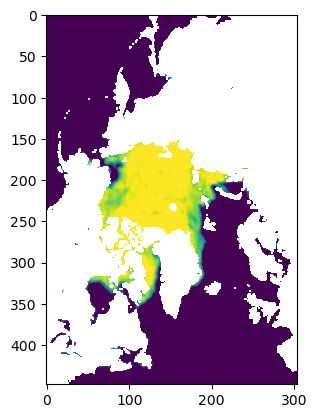

In [2]:
with open(DATAPATH / "sic.202212.npy", "rb") as f:
    data = np.load(f)

print(data.shape)
plt.imshow(data[0,:,:])

(448, 304)


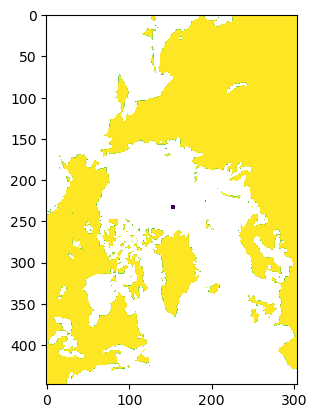

In [3]:
with open(DATAPATH / "sic.mask.npy", "rb") as f:
    mask = np.load(f)

print(mask.shape)
plt.imshow(mask)

## 1. Create an `xarray.Dataset` for the data

`xarray` was designed around the NetCDF file structure and CF-Conventions so it is perfect tool for creating CF-compliant NetCDF files.

To create a dataset, we pass a Python dictionary with the variable names as the keys and tuples containing the dimensions of each data variable and the numpy array containing the data.

```{note}
We can pass a lot more information to create a richer CF-compliant dataset with coordinate variables and variable attributes when we create a `Dataset`.  But for the purposes of this tutorial we will add coordinates and attributes step-by-step.  I'll show an example of defining a Dataset in _one go_ at the end of the tutorial.
```

In [4]:
df = xr.Dataset(
    {
        "sic": (("time", "y", "x"), data), 
        "sic_mask": (("y", "x"), mask)
    }
)
df

<xarray.Dataset> Size: 17MB
Dimensions:   (time: 31, y: 448, x: 304)
Dimensions without coordinates: time, y, x
Data variables:
    sic       (time, y, x) float32 17MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sic_mask  (y, x) float32 545kB nan nan nan nan nan ... nan nan nan nan nan

Variable, dimension, attribute and group names should start with a letter but can be composed of upper and lower case letters (`A-Za-z`), digits (`0-9`) and underscores (`_`).  It is helpful to keep variable names short and following domain specific conventions.  Avoid just making names up when a commonly used term is available.  In this example, `sic` is a commonly used acronym for Sea Ice Concentration.  The [CF-Standard Name Table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html) includes standard variable names from the Atmospheric Model Intercomparison Project (AMIP).

## Coordinates are the key knowing where your data are located

Coordinates locate data in space and time.  In netCDF, coordinates are contained in coordinate variables.  A coordinate variable is defined as a 1-dimensional variable with the same name as its dimension. 

```
float time[time]:
```

Common coordinates for data are _latitude_, _longitude_, _vertical_, and _time_.  For data in projected coordinate systems spatial coordinates are _x_ and _y_.  See the [Coordinate Types](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#coordinate-types) of the CF-Conventions document for more information.

For our sea ice concentration dataset we have three coordinates to define: `x`, `y` and `time`.

### Assign spatial (`x`,`y`) coordinates

The dataset has the spatial dimensions `x` and `y` but no geospatial coordinates; only mage coordinates that span 0 to 303 on the x-axis and 0 to 447 on the y-axis. 

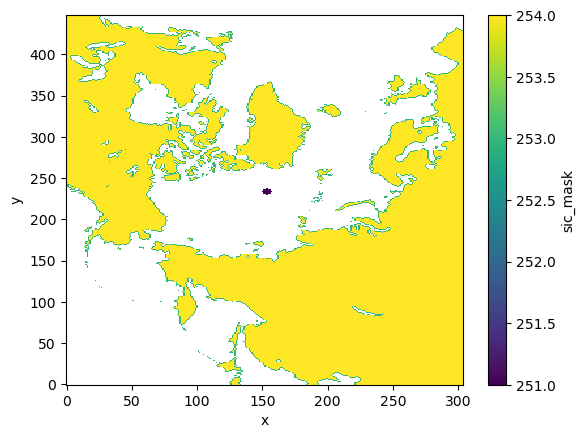

In [5]:
df.sic_mask.plot()

We need to assign geospatial coordinates that map to the image coordinates.  The geospatial coordinates are in a projected coordinate system, the NSIDC North Polar Stereographic.  We "designed" the grid with the following attributes.

- grid cell width: 25000. m
- grid cell height: 25000. m
- x-coordinate upper-left corner of upper left grid: -3850000. m
- y-coordinate upper-left corner of upper left grid: 5850000 m

Note grid parameters have the units of meters.

We can use these parameters to calculate the `x` and `y` coordinates of grid cell centers.

$$
x = (col + 0.5) \times width + x\_coord\_ul \\
y = (row + 0.5) \times height + y\_coord\_ul
$$

where $col$ and $row$ are the column and row indices in image coordinates.

This can also be expressed using linear algebra.

$$
\begin{bmatrix}
width & 0. & x\_coord\_ul\\
0. & height & y\_coord\_ul\\
0. & 0. & 0.
\end{bmatrix}
\begin{pmatrix}
col + 0.5\\
row + 0.5\\
1.
\end{pmatrix} =
\begin{pmatrix}
x\\
y\\
0.
\end{pmatrix}
$$

This is called an Affine matrix.  We can use the python package `affine` to calculate `x` and `y` coordinates.

First, we define the affine matrix and assign this to the dataset using to `rioxarray` `rio` accessor `write_transform`.  The `nsidc_polar_stereo_north` coordinate variable is added to the dataset.  This is the name of the _grid mapping_ that relates coordinates to the Earth.  If you click on the file icon, you can see that `nsidc_polar_stereo_north` has one attribute; GeoTransform.  This contains the same information as the affine matix but is in a slightly different form used by GDAL, which is the backend to `rasterio` and `rioxarray`. 

In [6]:
transform = Affine(25000., 0., -3850000, 0., -25000., 5850000.)
df.rio.write_transform(transform, inplace=True, grid_mapping_name="nsidc_polar_stereo_north")
df

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 31, y: 448, x: 304)
Coordinates:
    nsidc_polar_stereo_north  int64 8B 0
Dimensions without coordinates: time, y, x
Data variables:
    sic                       (time, y, x) float32 17MB 0.0 0.0 0.0 ... 0.0 0.0
    sic_mask                  (y, x) float32 545kB nan nan nan ... nan nan nan

The affine matrix can be used for matrix multiplication as

```
(x, y) = affine_matrix * (col, row)
```

`col` and `row` can be integers or arrays.  So here, I use the `numpy.arange` array generator to create column and row indices of the grid cell centers.

In [7]:
df = df.assign_coords(
    {
        "x": (df.rio.transform() * (np.arange(df.sizes['x'])+0.5, 0))[0],
        "y": (df.rio.transform() * (0, np.arange(df.sizes['y'])+0.5))[1]
    }
)

Now, when we plot `mask`, the x and y coordinates are in the projected coordinate system. 

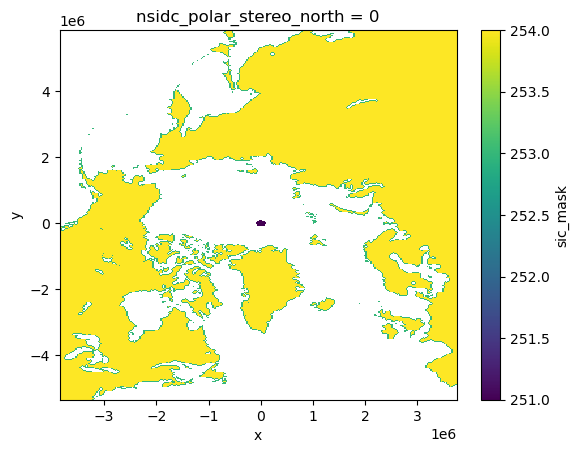

In [8]:
df.sic_mask.plot()

We need to do one final step.  We have a coordinate system that can be used to locate grid cells in projected coordinate space but we do not have any information on how these coordinates relate to the Earth; the _grid mapping_.  This is the Coordinate Reference System (CRS).  This can be done using the `rioxarray` `rio` accessor method `write_crs`, which takes an EPSG code.

Clicking on the file icon to see the attributes of `nsidc_polar_stereo_north` we can see that a lot more information has been added.  This information includes the CRS in Well Known Text (WKT) format, along with the projection parameters and ellipsoid definition.

In [9]:
df.rio.write_crs(3411, inplace=True, grid_mapping_name="nsidc_polar_stereo_north")
df

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 31, y: 448, x: 304)
Coordinates:
  * x                         (x) float64 2kB -3.838e+06 ... 3.738e+06
  * y                         (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
    nsidc_polar_stereo_north  int64 8B 0
Dimensions without coordinates: time
Data variables:
    sic                       (time, y, x) float32 17MB 0.0 0.0 0.0 ... 0.0 0.0
    sic_mask                  (y, x) float32 545kB nan nan nan ... nan nan nan

### Assign the `time` coordinate

We can locate grid cells in space but not in time.  We need to define a time coordinate.  The most convenient way to do this is to use `pandas.date_range`.

In [10]:
import pandas as pd
time = pd.date_range('2022-12-1', '2022-12-31', freq='D')
time

DatetimeIndex(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10', '2022-12-11', '2022-12-12',
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-17', '2022-12-18', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='D')

In [11]:
df = df.assign_coords({'time': time})
df

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 31, y: 448, x: 304)
Coordinates:
  * x                         (x) float64 2kB -3.838e+06 ... 3.738e+06
  * y                         (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
    nsidc_polar_stereo_north  int64 8B 0
  * time                      (time) datetime64[ns] 248B 2022-12-01 ... 2022-...
Data variables:
    sic                       (time, y, x) float32 17MB 0.0 0.0 0.0 ... 0.0 0.0
    sic_mask                  (y, x) float32 545kB nan nan nan ... nan nan nan

## But what do these variables mean?

At the moment, the data variables and coordinate variables are just numbers.  We don't know anything about what these numbers represent.  We need to add attributes to describe the variables.

All variables are required to have a `units` attribute if the data are dimensional.  If a data variable is `air_temperature` then it should have units Kelvin or degrees Celsius.  For dimensionless data, such as sea ice concentration, a `units` attribute is not required but to avoid ambiguity the `units` attribute can be set to 1.

`long_name` and `standard_name` attributes are not required but use of at least one of these is recommended.  `long_name` provides a description of the variable. that can be used for labelling plots  For the `sic` variable, an appropriate `long_name` is `"sea ice concentration"`.

The purpose of `standard_name` is to provide an unambiguous description of the variable and facilitate interoperability.  `standard_name` attributes should be from a [controlled vocabulary]() defined as part of CF-Convention [Standard Name Table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html).  For sea ice concentration, the `standard_name` is `sea_ice_area_fraction`.  `standard_names` should be lower case and use `_` instead of spaces.  The expected units are also provided in the [Standard Name Table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html).  For more information on standard names see [Section 3.3 of CF Convention 1.11](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#standard-name)

### Add attributes for data variables

In [12]:
attrs = {
    "sic": {
        "units": 1,
        "long_name": "Sea Ice Concentration",
        "standard_name": "sea_ice_area_fraction",
        "grid_mapping_name": "nsidc_polar_stereo_north",
    },
    "sic_mask": {
        "long_name": "sea ice mask flags",
        "standard_name": "sea_ice_area_fraction_mask",
        "flag_values": "251 252 253 254",
        "flag_meanings": "pole_hole_mask unused coast land",
        "grid_mapping_name": "nsidc_polar_stereo_north",
    },
}   

### Add attributes for coordinate variables

Coordinate variables also need attributes.  If a dataset has geographic spatial coordinates, i.e. _Latitude_ and _Longitude_, only `units`, `long_name` and `standard_name` attributes are necessary.  For example:

```
{
    "lat": {
        "long_name": "latitude",
        "units": "degrees_north",
        "standard_name": "latitude",
    },
    "lon": {
        "long_name": "longitude",
        "units": "degrees_east",
        "standard_name": "longitude",
    }
}
```

The Sea Ice Concentration data set is a projected coordinated system; the NSIDC Polar Stereographic North.  The attributes follow the same pattern as for latitude and longitude with `long_name`, `units` and `standard_name`.

We'll add these to `attrs` Python dictionary

In [13]:
attrs["y"] = {
    "long_name": "y coordinate of projection",
    "units": "m",
    "standard_name": "projection_y_coordinate",
    }

attrs["x"] = {
    "long_name": "x coordinate of projection",
    "units": "m",
    "standard_name": "projection_x_coordinate",
     }

#### Time is precious!

The other coordinate that needs attributes is `time`.  Times are stored in NetCDF as increments from a start date or time.  The `units` attribute is required to define the time unit for the increment and the datetime that increments start from.  An example is

`days since 1900-01-01 00:00:00`

`seconds`, `minutes`, `hours`, and `days` are all acceptable time increments.  Do **not** use _years_ or _months_ because these are not constant in length.  You can also specify a time zone.  The default time zone is UTC.

Only `units` are required attributes for a time coordinate.  However, it is useful to add a `long_name` so that labels are automatically generated in plotting functions.   

It is also helpful to add a `calendar` attribute.  Most observational datasets will use the [_Gregorian_ calendar](https://en.wikipedia.org/wiki/Gregorian_calendar), which is the calendar used in most parts of the world.  This is the default `standard` calendar, which is a mixed Julian/Gregorian calendar.  Atmospheric reanalyses, such as ERA5, MERRA-2 and CFSR also use the Gregorian Calendar.  However, climate models sometimes use 360 day years and ignore leap years. 
 Dates before 1582-10-15 00:00:00 depend on if the `standard` (mixed Julien/Gegorian) or Proleptic Gregorian (which extends the Gregorian Leap Year rules back before the Gregorian mandate).  

See [Section 4.1.1 Calendar](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#calendar) for more information.

```{warning}
**There is no year zero**!  Or is there.  It depends on the calendar.  Some of you may remember the endless debates about whether 1999 or 2000 was the end of the Milennium.  Basically it came down to whether we started counting years at 1 or 0.  And what happens when you switch from Common Era to Before Common Era.  Do dates count back year 1 CE, year 0 CE, year 1 BCE; or year 1 CE, year 1 BCE.  It is best (in my mind at least) to avoid the trouble and assign units avoiding the ambiguity of year zero.  Some tools breaks when there is a year zero.  Either way, there is definitely no month or day zero.  So `days since 0-0-0 00:00:00` is meaningless!
```

Because the time `units` and `calendar` are used to decode and encode the time coordinate when the file is read and written, `units` and `calendar` are added to the encoding information for the time variable not the attributes.  


In [14]:
attrs["time"] = {
    "long_name": "time",
}

The attributes can be assigned using a `for` loop.

In [15]:
for var, val in attrs.items():
    df[var].attrs = val
df

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 31, y: 448, x: 304)
Coordinates:
  * x                         (x) float64 2kB -3.838e+06 ... 3.738e+06
  * y                         (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
    nsidc_polar_stereo_north  int64 8B 0
  * time                      (time) datetime64[ns] 248B 2022-12-01 ... 2022-...
Data variables:
    sic                       (time, y, x) float32 17MB 0.0 0.0 0.0 ... 0.0 0.0
    sic_mask                  (y, x) float32 545kB nan nan nan ... nan nan nan

### Add Global Attributes

While not required by CF Conventions, it is helpful to provide the title of the dataset, the source, any processing history and a reference for the dataset.  This can increase _reusability_.  Because this information does not apply to any one variable but the dataset as a whole, they are assigned as _global attributes_.

Here, we will add `title`, `source`, `processing history` and a `reference`.  `processing_history` could also include any scripts used to create the dataset.

In [16]:
global_attrs = {
    "title": "NSIDC Passive Microwave Sea Ice Concentration data (NSIDC-0051)",
    "source": "https://doi.org/10.5067/MPYG15WAA4WX",
    "reference": ("DiGirolamo, N., Parkinson, C. L., Cavalieri, D. J., Gloersen, P. \n"
                 "& Zwally, H. J. (2022). Sea Ice Concentrations from Nimbus-7 SMMR \n"
                 "and DMSP SSM/I-SSMIS Passive Microwave Data, Version 2 [Data Set]. \n"
                 "Boulder, Colorado USA. NASA National Snow and Ice Data Center \n"
                 "Distributed Active Archive Center. https://doi.org/10.5067/MPYG15WAA4WX. \n"
                 "Date Accessed 08-18-2024."),
    "processing_history": ("Original sea ice concentration grids extracted and non-data\n"
                           " values set to _Fill_Value.  Masked grid cells extracted to\n"
                           " sic_mask grid"),
}
df.attrs = global_attrs
df

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 31, y: 448, x: 304)
Coordinates:
  * x                         (x) float64 2kB -3.838e+06 ... 3.738e+06
  * y                         (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
    nsidc_polar_stereo_north  int64 8B 0
  * time                      (time) datetime64[ns] 248B 2022-12-01 ... 2022-...
Data variables:
    sic                       (time, y, x) float32 17MB 0.0 0.0 0.0 ... 0.0 0.0
    sic_mask                  (y, x) float32 545kB nan nan nan ... nan nan nan
Attributes:
    title:               NSIDC Passive Microwave Sea Ice Concentration data (...
    source:              https://doi.org/10.5067/MPYG15WAA4WX
    reference:           DiGirolamo, N., Parkinson, C. L., Cavalieri, D. J., ...
    processing_history:  Original sea ice concentration grids extracted and n...

## Packaging the data for use

We now have a dataset and variables that have coordinates that are related to Earth by a Coordinate Reference System (CRS) in the `grid_mapping_name`.  The variables have attributes so that we know what each variable is, how it should be interpretted and what the units are.  We have added some dataset information to help uses understand where the data can from and how it was processing in the global attributes.

We now want to write the dataset to a file.  We need to set a couple of _encodings_ that tell the NetCDF library how to write the data to the file.  We need to define a `_FillValue` that is the value used to represent NaN in the file.  We might want to compress the file to save space.  We may also want to chunk the file to help with out of memory operations.  All this information is provided as encodings for each variable.

```{note}
It is better not to compress coordinate variables.  These are normally 1-dimensional vectors so don't take up as much space as the data variables.  

Also, coordinate variables **do not** have missing values so no `_Fill_Value` is set.  If a coordinate value is missing then that coordinate doesn't exist!
```

In [24]:
encoding = {
    "sic": {
        "zlib": True,   # This uses the zlib library to compress the data
        "complevel": 9,  # The maximum compression.  For large files this will take a while to write
        "_FillValue": 9.9692099683868690e+36  # The default fill value for floating point
    },
    "sic_mask": {
        "zlib": True,   # This uses the zlib library to compress the data
        "complevel": 9,  # The maximum compression.  For large files this will take a while to write
        "_FillValue": -127,  # The default fill value for floating point
        "dtype": "byte",
    },
    "time": {
        "units": "days since 1970-01-01 00:00:00",
        "calendar": "standard",  # To be explicit
    },
}   

## Write the dataset to a file

Now that all the information is in the dataset and we have set up the encoding, the dataset can be written to a file.  This is done using the `to_netcdf` method.

In [25]:
df.to_netcdf("test.nc", encoding=encoding)

In [26]:
!ncdump -h test.nc

netcdf test {
dimensions:
	time = 31 ;
	y = 448 ;
	x = 304 ;
variables:
	float sic(time, y, x) ;
		sic:_FillValue = 9.96921e+36f ;
		sic:units = 1LL ;
		sic:long_name = "Sea Ice Concentration" ;
		sic:standard_name = "sea_ice_area_fraction" ;
		sic:grid_mapping_name = "nsidc_polar_stereo_north" ;
	byte sic_mask(y, x) ;
		sic_mask:_FillValue = -127b ;
		sic_mask:long_name = "sea ice mask flags" ;
		sic_mask:standard_name = "sea_ice_area_fraction_mask" ;
		sic_mask:flag_values = "251 252 253 254" ;
		sic_mask:flag_meanings = "pole_hole_mask unused coast land" ;
		sic_mask:grid_mapping_name = "nsidc_polar_stereo_north" ;
	double x(x) ;
		x:_FillValue = NaN ;
		x:long_name = "x coordinate of projection" ;
		x:units = "m" ;
		x:standard_name = "projection_x_coordinate" ;
	double y(y) ;
		y:_FillValue = NaN ;
		y:long_name = "y coordinate of projection" ;
		y:units = "m" ;
		y:standard_name = "projection_y_coordinate" ;
	int64 nsidc_polar_stereo_north ;
		nsidc_polar_stereo_north:crs_wkt = "